# ViT for Image Classification

In [ ]:
# # Install or upgrade the required Python packages using pip
# %pip install -U -q evaluate tensorflow transformers datasets>=2.14.5 mlflow 2>/dev/null

In [ ]:
# %pip install accelerate==0.26.1

In [ ]:
# %pip install --upgrade tensorflow

In [4]:
import accelerate

c:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# %pip install imbalanced-learn
# %pip install evaluate


In [6]:
import warnings  # Import the 'warnings' module for handling warnings
warnings.filterwarnings("ignore")  # Ignore warnings during execution

import gc  # Import the 'gc' module for garbage collection
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import Pandas for data manipulation
import itertools  # Import 'itertools' for iterators and looping
from collections import Counter  # Import 'Counter' for counting elements
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

# Import custom modules and classes
from imblearn.over_sampling import RandomOverSampler # import RandomOverSampler
import evaluate  # Import the 'evaluate' module
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes
from transformers import (  # Import various modules from the Transformers library
    TrainingArguments,  # For training arguments
    Trainer,  # For model training
    ViTImageProcessor,  # For processing image data with ViT models
    ViTForImageClassification,  # ViT model for image classification
    DefaultDataCollator  # For collating data in the default way
)
import torch  # Import PyTorch for deep learning
from torch.utils.data import DataLoader  # For creating data loaders
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)

In [7]:
# Import the necessary module from the Python Imaging Library (PIL).
from PIL import ImageFile

# Enable the option to load truncated images.
# This setting allows the PIL library to attempt loading images even if they are corrupted or incomplete.
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [8]:
from pathlib import Path
import pandas as pd

# Initialize empty lists to store file names and labels
file_names = []
labels = []

# Define the path to your dataset
dataset_path = Path("C:/Users/Ramkrishna/Downloads/Plant_leave_diseases_dataset_with_augmentation")

# List of folder names with their corresponding class labels
folder_names = [
    "Apple___Apple_scab",
    "Apple___Black_rot",
    "Apple___Cedar_apple_rust",
    "Apple___healthy",
    "Background_without_leaves",
    "Blueberry___healthy",
    "Cherry___Powdery_mildew",
    "Cherry___healthy",
    "Corn___Cercospora_leaf_spot Gray_leaf_spot",
    "Corn___Common_rust",
    "Corn___healthy",
    "Corn___Northern_Leaf_Blight",
    "Grape___Black_rot",
    "Grape___Esca_(Black_Measles)",
    "Grape___healthy",
    "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
    "Orange___Haunglongbing_(Citrus_greening)",
    "Peach___Bacterial_spot",
    "Peach___healthy",
    "Pepper,_bell___Bacterial_spot",
    "Pepper,_bell___healthy",
    "Potato___Early_blight",
    "Potato___healthy",
    "Potato___Late_blight",
    "Raspberry___healthy",
    "Soybean___healthy",
    "Squash___Powdery_mildew",
    "Strawberry___healthy",
    "Strawberry___Leaf_scorch",
    "Tomato___Bacterial_spot",
    "Tomato___Early_blight",
    "Tomato___healthy",
    "Tomato___Late_blight",
    "Tomato___Leaf_Mold",
    "Tomato___Septoria_leaf_spot",
    "Tomato___Spider_mites Two-spotted_spider_mite",
    "Tomato___Target_Spot",
    "Tomato___Tomato_mosaic_virus",
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus"
]

# Iterate through each folder
for folder in folder_names:
    folder_path = dataset_path / folder
    # Check if the folder exists
    if folder_path.exists() and folder_path.is_dir():
        label = folder.replace('___', ' ')  # Replace triple underscores with spaces for label readability
        # Iterate through each image file in the folder
        for file in folder_path.glob('*.*'):
            file_names.append(str(file))  # Add the file path to the list
            labels.append(label)  # Add the corresponding label to the list
    else:
        print(f"Folder not found: {folder_path}")

# Print the total number of file names and labels
print("Number of files: ", len(file_names))
print("Number of labels: ", len(labels))

# Create a pandas dataframe from the collected file names and labels
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})

# Display the first few rows of the dataframe
print(df.head())


Number of files:  61486
Number of labels:  61486
                                               image             label
0  C:\Users\Ramkrishna\Downloads\Plant_leave_dise...  Apple Apple_scab
1  C:\Users\Ramkrishna\Downloads\Plant_leave_dise...  Apple Apple_scab
2  C:\Users\Ramkrishna\Downloads\Plant_leave_dise...  Apple Apple_scab
3  C:\Users\Ramkrishna\Downloads\Plant_leave_dise...  Apple Apple_scab
4  C:\Users\Ramkrishna\Downloads\Plant_leave_dise...  Apple Apple_scab


In [9]:
import os

def list_subfolders(folder_path):
    subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
    return subfolders

# Example usage:
folder_path = 'C:/Users/Ramkrishna/Downloads/Plant_leave_diseases_dataset_with_augmentation'
subfolders = list_subfolders(folder_path)
print("Sub-folders in", folder_path, "are:")
for subfolder in subfolders:
    print(subfolder)


Sub-folders in C:/Users/Ramkrishna/Downloads/Plant_leave_diseases_dataset_with_augmentation are:
C:/Users/Ramkrishna/Downloads/Plant_leave_diseases_dataset_with_augmentation\Apple___Apple_scab
C:/Users/Ramkrishna/Downloads/Plant_leave_diseases_dataset_with_augmentation\Apple___Black_rot
C:/Users/Ramkrishna/Downloads/Plant_leave_diseases_dataset_with_augmentation\Apple___Cedar_apple_rust
C:/Users/Ramkrishna/Downloads/Plant_leave_diseases_dataset_with_augmentation\Apple___healthy
C:/Users/Ramkrishna/Downloads/Plant_leave_diseases_dataset_with_augmentation\Background_without_leaves
C:/Users/Ramkrishna/Downloads/Plant_leave_diseases_dataset_with_augmentation\Blueberry___healthy
C:/Users/Ramkrishna/Downloads/Plant_leave_diseases_dataset_with_augmentation\Cherry___healthy
C:/Users/Ramkrishna/Downloads/Plant_leave_diseases_dataset_with_augmentation\Cherry___Powdery_mildew
C:/Users/Ramkrishna/Downloads/Plant_leave_diseases_dataset_with_augmentation\Corn___Cercospora_leaf_spot Gray_leaf_spot
C:

In [10]:
df.head()

,image,label
0,C:\Users\Ramkrishna\Downloads\Plant_leave_dise...,Apple Apple_scab
1,C:\Users\Ramkrishna\Downloads\Plant_leave_dise...,Apple Apple_scab
2,C:\Users\Ramkrishna\Downloads\Plant_leave_dise...,Apple Apple_scab
3,C:\Users\Ramkrishna\Downloads\Plant_leave_dise...,Apple Apple_scab
4,C:\Users\Ramkrishna\Downloads\Plant_leave_dise...,Apple Apple_scab


In [11]:
df['label'].unique()

array(['Apple Apple_scab', 'Apple Black_rot', 'Apple Cedar_apple_rust',
       'Apple healthy', 'Background_without_leaves', 'Blueberry healthy',
       'Cherry Powdery_mildew', 'Cherry healthy',
       'Corn Cercospora_leaf_spot Gray_leaf_spot', 'Corn Common_rust',
       'Corn healthy', 'Corn Northern_Leaf_Blight', 'Grape Black_rot',
       'Grape Esca_(Black_Measles)', 'Grape healthy',
       'Grape Leaf_blight_(Isariopsis_Leaf_Spot)',
       'Orange Haunglongbing_(Citrus_greening)', 'Peach Bacterial_spot',
       'Peach healthy', 'Pepper,_bell Bacterial_spot',
       'Pepper,_bell healthy', 'Potato Early_blight', 'Potato healthy',
       'Potato Late_blight', 'Raspberry healthy', 'Soybean healthy',
       'Squash Powdery_mildew', 'Strawberry healthy',
       'Strawberry Leaf_scorch', 'Tomato Bacterial_spot',
       'Tomato Early_blight', 'Tomato healthy', 'Tomato Late_blight',
       'Tomato Leaf_Mold', 'Tomato Septoria_leaf_spot',
       'Tomato Spider_mites Two-spotted_spider_mit

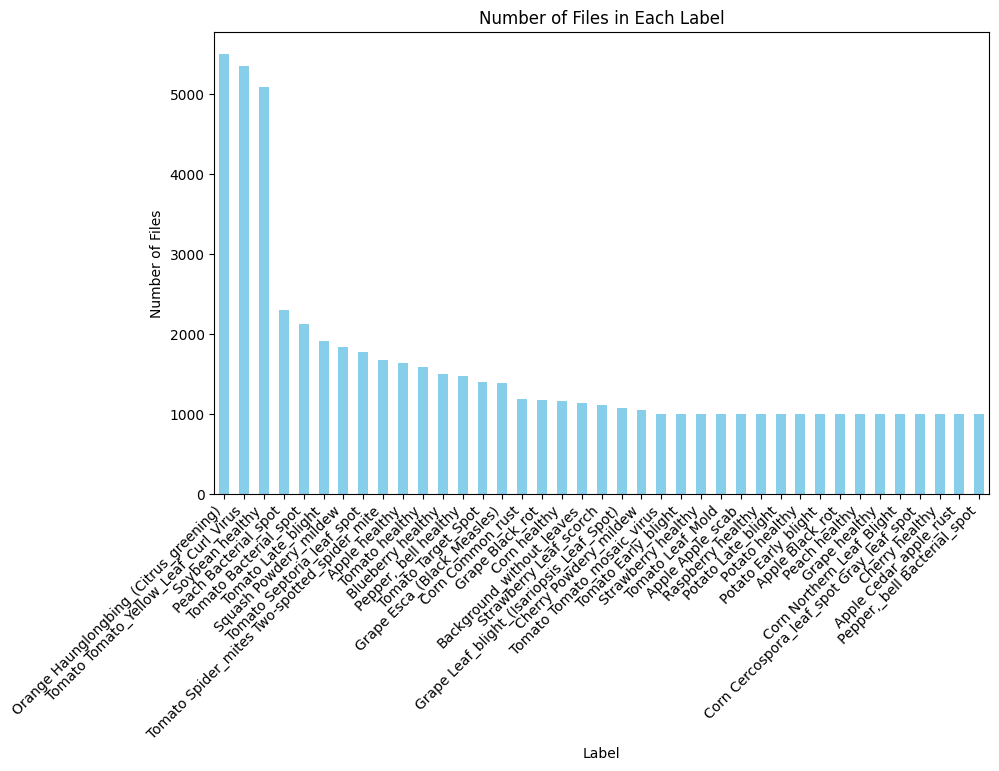

In [12]:
import matplotlib.pyplot as plt

label_counts = df['label'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Files in Each Label')
plt.xlabel('Label')
plt.ylabel('Number of Files')
plt.xticks(rotation=45, ha='right')
plt.show()

In [13]:
y = df[['label']]

# Drop the 'label' column from the DataFrame 'df' to separate features from the target variable
df = df.drop(['label'], axis=1)

# Create a RandomOverSampler object with a specified random seed (random_state=83)
ros = RandomOverSampler(random_state=83)

# Use the RandomOverSampler to resample the dataset by oversampling the minority class
# 'df' contains the feature data, and 'y_resampled' will contain the resampled target variable
df, y_resampled = ros.fit_resample(df, y)

# Delete the original 'y' variable to save memory as it's no longer needed
del y

# Add the resampled target variable 'y_resampled' as a new 'label' column in the DataFrame 'df'
df['label'] = y_resampled

# Delete the 'y_resampled' variable to save memory as it's no longer needed
del y_resampled

# Perform garbage collection to free up memory used by discarded variables
gc.collect()

print(df.shape)

(214773, 2)


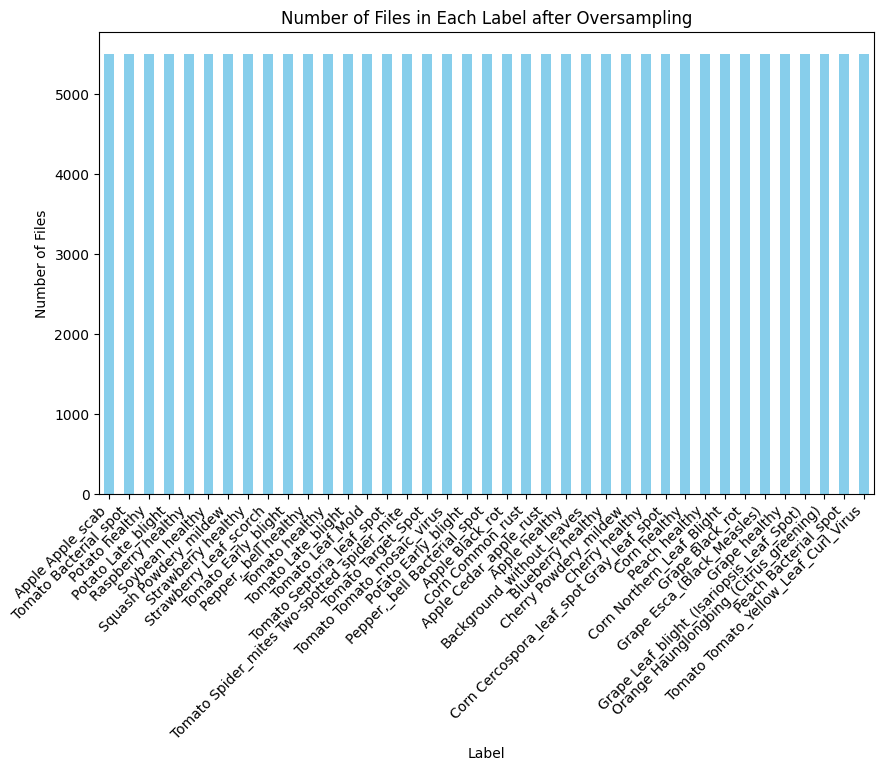

In [14]:
import matplotlib.pyplot as plt

label_counts = df['label'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Files in Each Label after Oversampling')
plt.xlabel('Label')
plt.ylabel('Number of Files')
plt.xticks(rotation=45, ha='right')
plt.show()

In [15]:
# Create a dataset from a Pandas DataFrame.
dataset = Dataset.from_pandas(df).cast_column("image", Image())

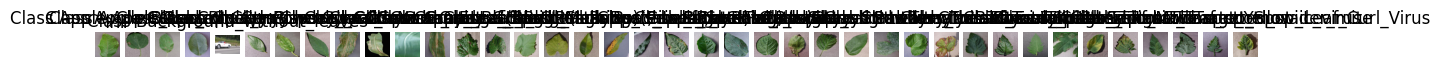

In [16]:
import matplotlib.pyplot as plt
from PIL import Image

# Assuming you have already loaded and processed your dataset
# and have access to the dataset object containing the 'image' and 'label' columns.

# Find unique classes in the 'label' column
unique_classes = df['label'].unique()

# Create a dictionary to store one image path per class
one_image_per_class = {}

# Iterate through each unique class and find the first corresponding image path
for class_label in unique_classes:
    # Get the first image path for each class
    image_path = df[df['label'] == class_label]['image'].iloc[0]
    one_image_per_class[class_label] = image_path

# Display one image from each class
fig, axs = plt.subplots(1, len(unique_classes), figsize=(15, 5))

for i, (class_label, image_path) in enumerate(one_image_per_class.items()):
    # Load the image using PIL
    img = Image.open(image_path)

    # Display the image
    axs[i].imshow(img)
    axs[i].set_title(f'Class {class_label}')
    axs[i].axis('off')

plt.show()

In [17]:
labels_list = list(set(labels))

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'Tomato Target_Spot', 1: 'Apple healthy', 2: 'Corn Cercospora_leaf_spot Gray_leaf_spot', 3: 'Raspberry healthy', 4: 'Pepper,_bell healthy', 5: 'Tomato Tomato_mosaic_virus', 6: 'Tomato Spider_mites Two-spotted_spider_mite', 7: 'Strawberry Leaf_scorch', 8: 'Corn healthy', 9: 'Tomato Late_blight', 10: 'Blueberry healthy', 11: 'Corn Northern_Leaf_Blight', 12: 'Grape healthy', 13: 'Grape Leaf_blight_(Isariopsis_Leaf_Spot)', 14: 'Cherry healthy', 15: 'Apple Apple_scab', 16: 'Apple Cedar_apple_rust', 17: 'Peach healthy', 18: 'Strawberry healthy', 19: 'Corn Common_rust', 20: 'Grape Black_rot', 21: 'Tomato Tomato_Yellow_Leaf_Curl_Virus', 22: 'Squash Powdery_mildew', 23: 'Tomato Bacterial_spot', 24: 'Pepper,_bell Bacterial_spot', 25: 'Potato Late_blight', 26: 'Soybean healthy', 27: 'Potato Early_blight', 28: 'Orange Haunglongbing_(Citrus_greening)', 29: 'Peach Bacterial_spot', 30: 'Cherry Powdery_mildew', 31: 'Background_without_leaves', 32: 'Tomato Early_blight', 3

In [18]:
# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
dataset = dataset.cast_column('label', ClassLabels)

# Splitting the dataset into training and testing sets using an 80-20 split ratio.
split_dataset = dataset.train_test_split(test_size=0.2, shuffle=True, stratify_by_column="label")

# Extracting the training data from the split dataset.
train_data = split_dataset['train']

# Extracting the validation and test data from the split dataset.
second_split_dataset = split_dataset['test'].train_test_split(test_size=0.5, shuffle=True, stratify_by_column="label")


Casting the dataset: 100%|██████████| 214773/214773 [00:00<00:00, 3773634.89 examples/s]


In [19]:
validation_data = second_split_dataset['train']

In [20]:
test_data = second_split_dataset['test']

In [21]:
# Define the pre-trained ViT model string
model_str = 'google/vit-base-patch16-224-in21k'

# Create a processor for ViT model input from the pre-trained model
processor = ViTImageProcessor.from_pretrained(model_str)

# Retrieve the image mean and standard deviation used for normalization
image_mean, image_std = processor.image_mean, processor.image_std

# Get the size (height) of the ViT model's input images
size = processor.size["height"]
print("Size: ", size)

# Define a normalization transformation for the input images
normalize = Normalize(mean=image_mean, std=image_std)

# Define a set of transformations for training data
_train_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        RandomRotation(20),               # Apply random rotation
        RandomAdjustSharpness(2),         # Adjust sharpness randomly
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a set of transformations for validation data
_val_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a set of transformations for test data
_test_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Define a function to apply test transformations to a batch of examples
def test_transforms(examples):
    examples['pixel_values'] = [_test_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Size:  224


In [22]:
# Set the transforms for the training data
train_data.set_transform(train_transforms)

# Set the transforms for the validation data
validation_data.set_transform(val_transforms)

# Set the transforms for the test data
test_data.set_transform(test_transforms)

In [23]:
# Define a collate function that prepares batched data for model training.
def collate_fn(examples):
    # Stack the pixel values from individual examples into a single tensor.
    pixel_values = torch.stack([example["pixel_values"] for example in examples])

    # Convert the label strings in examples to corresponding numeric IDs using label2id dictionary.
    labels = torch.tensor([example['label'] for example in examples])

    # Return a dictionary containing the batched pixel values and labels.
    return {"pixel_values": pixel_values, "labels": labels}

In [24]:
# Create a ViTForImageClassification model from a pretrained checkpoint with a specified number of output labels.
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))

# Configure the mapping of class labels to their corresponding indices for later reference.
model.config.id2label = id2label
model.config.label2id = label2id

# Calculate and print the number of trainable parameters in millions for the model.
print(model.num_parameters(only_trainable=True) / 1e6)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85.828647


In [25]:
# Load the accuracy metric from a module named 'evaluate'
accuracy = evaluate.load("accuracy")

# Define a function 'compute_metrics' to calculate evaluation metrics
def compute_metrics(eval_pred):
    # Extract model predictions from the evaluation prediction object
    predictions = eval_pred.predictions

    # Extract true labels from the evaluation prediction object
    label_ids = eval_pred.label_ids

    # Calculate accuracy using the loaded accuracy metric
    # Convert model predictions to class labels by selecting the class with the highest probability (argmax)
    predicted_labels = predictions.argmax(axis=1)

    # Calculate accuracy score by comparing predicted labels to true labels
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']

    # Return the computed accuracy as a dictionary with the key "accuracy"
    return {
        "accuracy": acc_score
    }


In [26]:
# Define the name of the evaluation metric to be used during training and evaluation.
metric_name = "accuracy"

# Define the name of the model, which will be used to create a directory for saving model checkpoints and outputs.
model_name = "plant_diesease_image_classifier"

# Define the number of training epochs for the model.
num_train_epochs = 10

# Create an instance of TrainingArguments to configure training settings.
args = TrainingArguments(
    # Specify the directory where model checkpoints and outputs will be saved.
    output_dir=model_name,

    # Specify the directory where training logs will be stored.
    logging_dir='./logs',

    # Define the evaluation strategy, which is performed at the end of each epoch.
    evaluation_strategy="epoch",

    # Set the learning rate for the optimizer.
    learning_rate=1e-5,

    # Define the batch size for training on each device.
    per_device_train_batch_size=32,

    # Define the batch size for evaluation on each device.
    per_device_eval_batch_size=8,

    # Specify the total number of training epochs.
    num_train_epochs=num_train_epochs,

    # Apply weight decay to prevent overfitting.
    weight_decay=0.02,

    # Set the number of warm-up steps for the learning rate scheduler.
    warmup_steps=50,

    # Disable the removal of unused columns from the dataset.
    remove_unused_columns=False,

    # Define the strategy for saving model checkpoints (per epoch in this case).
    save_strategy='epoch',

    # Load the best model at the end of training.
    load_best_model_at_end=True,

    # Limit the total number of saved checkpoints to save space.
    save_total_limit=1,

    # Specify that training progress should be reported to MLflow.
    report_to="mlflow"  # log to mlflow
)

In [27]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=validation_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor
)

In [28]:
# %pip install mlflow

In [29]:
trainer.evaluate()

100%|██████████| 2685/2685 [12:53:53<00:00, 17.29s/it]      


{'eval_loss': 3.679461717605591,
 'eval_accuracy': 0.006099548354053173,
 'eval_runtime': 46437.4302,
 'eval_samples_per_second': 0.462,
 'eval_steps_per_second': 0.058}

In [30]:
# %pip install --upgrade pillow


: 

In [31]:
trainer.train()

  0%|          | 1/53700 [01:24<1257:29:14, 84.30s/it]

In [ ]:
# Access the training and validation history
train_history = trainer.state.log_history

# Print the keys in one entry of train_history to identify the correct keys
if train_history:
    print("Keys in one entry of train_history:", train_history[0].keys())


In [ ]:
train_loss = []
train_accuracy = []
global_step = []

for entry in train_history:
    if 'eval_loss' in entry and 'eval_accuracy' in entry:
        train_loss.append(entry['eval_loss'])
        train_accuracy.append(entry['eval_accuracy'])
        global_step.append(entry['step'])

# Plot Evaluation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(global_step, train_loss, label='Evaluation Loss', color='red')
plt.title('Evaluation Loss')
plt.xlabel('Global Step')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(global_step, train_accuracy, label='Evaluation Accuracy', color='orange')
plt.title('Evaluation Accuracy')
plt.xlabel('Global Step')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Evaluate the post-training model's performance on the validation or test dataset.
# This function computes various evaluation metrics like accuracy, loss, etc.
# and provides insights into how well the model is performing.

trainer.evaluate()

Predicting on Test Data

In [ ]:
# Use the trained 'trainer' to make predictions on the 'test_data'.
outputs = trainer.predict(test_data)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

In [ ]:
outputs.metrics

In [ ]:
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)

    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 150:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))